In [32]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections
import matplotlib.pyplot as plt

if "../" not in sys.path:
  sys.path.append("../")
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [33]:
env = CliffWalkingEnv()

In [75]:
class PolicyEstimator():
    """
    Policy Function approximator. 
    """
    
    def __init__(self, learning_rate=0.01, scope="policy_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.action = tf.placeholder(dtype=tf.int32, name="action")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=env.action_space.n,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.action_probs = tf.squeeze(tf.nn.softmax(self.output_layer))
            self.picked_action_prob = tf.gather(self.action_probs, self.action)

            # Loss and train op
            self.loss = -tf.log(self.picked_action_prob) * self.target

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.action_probs, { self.state: state })

    def update(self, state, target, action, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target, self.action: action  }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [76]:
class ValueEstimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, learning_rate=0.1, scope="value_estimator"):
        with tf.variable_scope(scope):
            self.state = tf.placeholder(tf.int32, [], "state")
            self.target = tf.placeholder(dtype=tf.float32, name="target")

            # This is just table lookup estimator
            state_one_hot = tf.one_hot(self.state, int(env.observation_space.n))
            self.output_layer = tf.contrib.layers.fully_connected(
                inputs=tf.expand_dims(state_one_hot, 0),
                num_outputs=1,
                activation_fn=None,
                weights_initializer=tf.zeros_initializer)

            self.value_estimate = tf.squeeze(self.output_layer)
            self.loss = tf.squared_difference(self.value_estimate, self.target)

            self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
            self.train_op = self.optimizer.minimize(
                self.loss, global_step=tf.contrib.framework.get_global_step())        
    
    def predict(self, state, sess=None):
        sess = sess or tf.get_default_session()
        return sess.run(self.value_estimate, { self.state: state })

    def update(self, state, target, sess=None):
        sess = sess or tf.get_default_session()
        feed_dict = { self.state: state, self.target: target }
        _, loss = sess.run([self.train_op, self.loss], feed_dict)
        return loss

In [11]:
action_descriptions = { 0: 'up', 1: 'right', 2: 'down', 3: 'left' }

def plot_information(plot_v = False):
    policies = np.array([policy_estimator.predict(s) for s in range(env.observation_space.n)])
    fig, axes = plt.subplots(2, 2, figsize=(17, 7))
    for j in range(4):
        axes.flat[j].set_title(f'Action {action_descriptions[j]}')
        image = policies[:, j].reshape((4, -1))
        im = axes.flat[j].imshow(image)
    fig.colorbar(im, ax=axes.ravel().tolist())

    if (plot_v):
        fig = plt.figure(figsize=(17, 4))
        values = np.array([value_estimator.predict(s) for s in range(env.observation_space.n)])
        plt.imshow(values.reshape((4, -1)))
        plt.title('State values')
        plt.colorbar()
    plt.show()

In [89]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = env.reset()
        
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            
            # Keep track of the transition
            episode.append(Transition(
              state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
#             print("\rStep {} @ Episode {}/{} ({})".format(
#                     t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            if transition.state > 36:
                print('wtf')
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
            
        if i_episode % 500 == 0:
            print(f'Episode {i_episode}')
            print(f'Policy 36: {estimator_policy.predict(36)}, policy 24: {estimator_policy.predict(24)}')
            plot_information(True)
    
    return stats

Episode 0
Policy 36: [0.21533066 0.2827295  0.2779444  0.22399549], policy 24: [0.2101463  0.27455083 0.26990414 0.24539879]


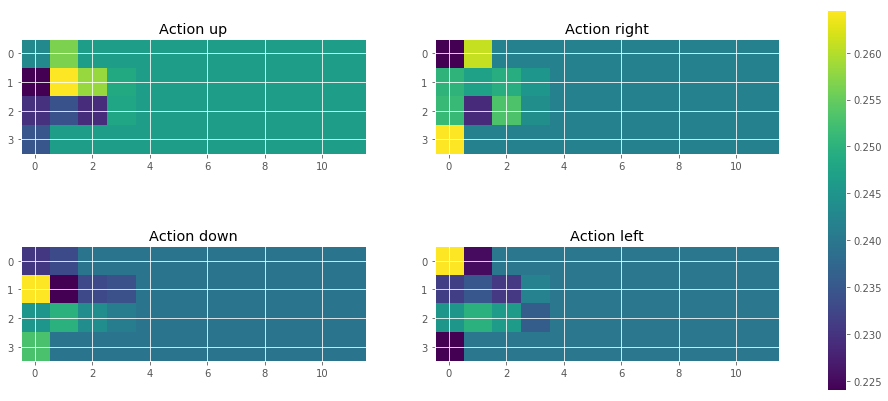

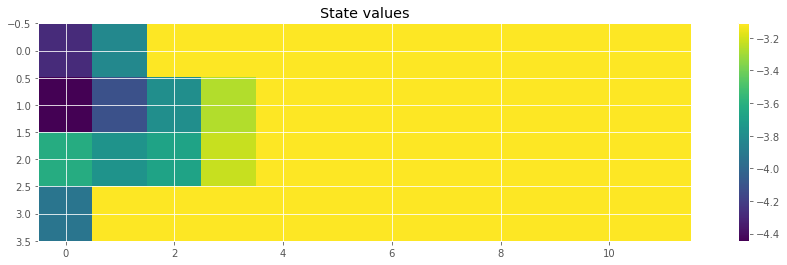

Episode 500
Policy 36: [0.09811287 0.68796223 0.11352523 0.10039961], policy 24: [0.07074811 0.24047005 0.44162777 0.24715415]


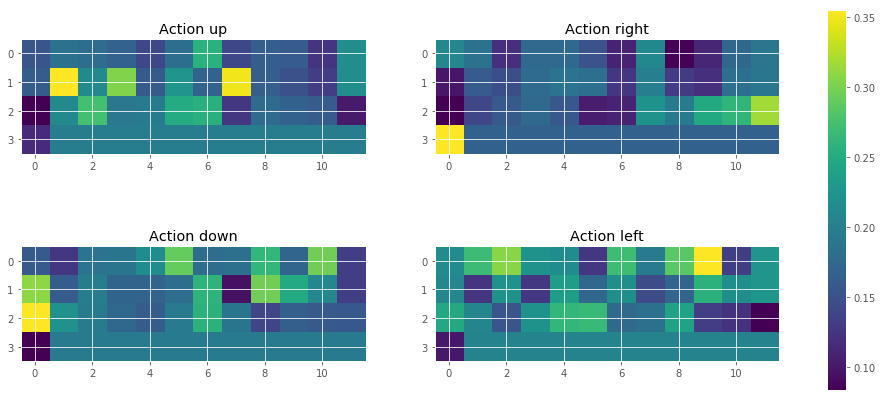

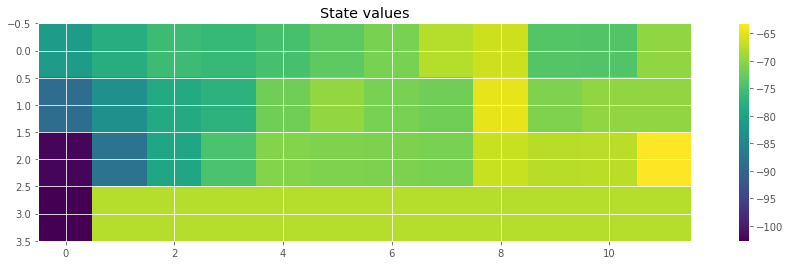

Episode 1000
Policy 36: [0.04910218 0.8117594  0.0744399  0.0646986 ], policy 24: [0.06026725 0.23331064 0.47419488 0.23222722]


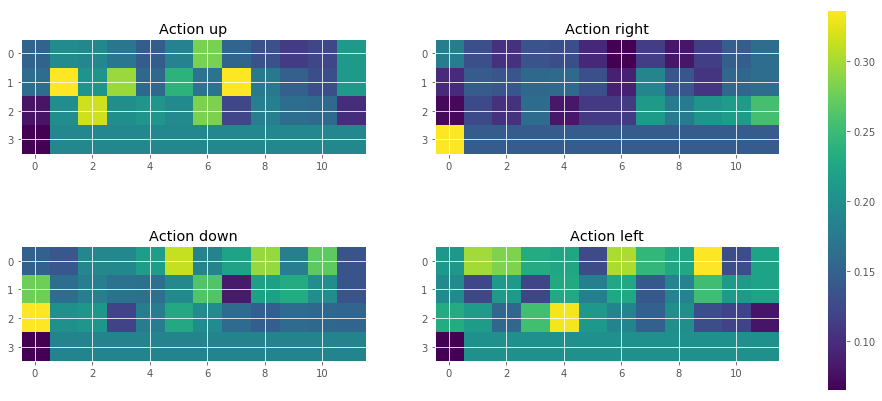

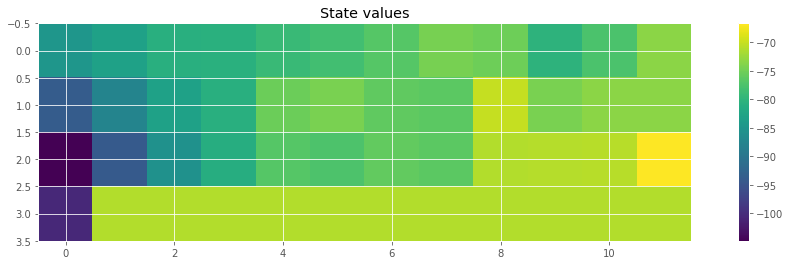

Episode 1500
Policy 36: [0.02782161 0.9052419  0.03038755 0.03654893], policy 24: [0.06408618 0.35773042 0.3438406  0.23434284]


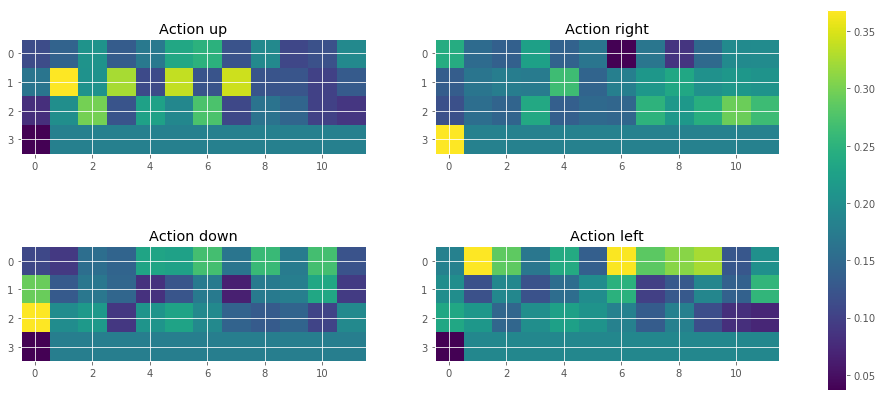

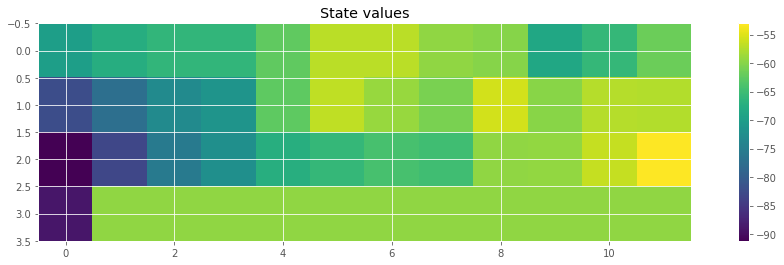

Episode 2000
Policy 36: [0.13313513 0.8189556  0.02700605 0.02090333], policy 24: [0.06209276 0.7603662  0.10134958 0.07619134]


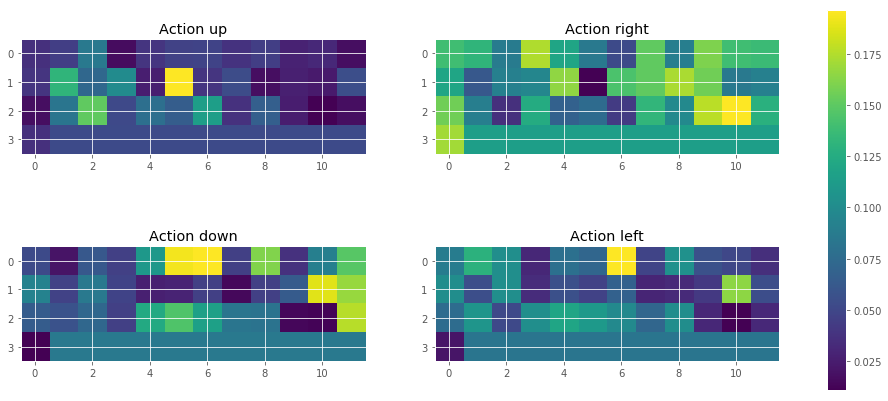

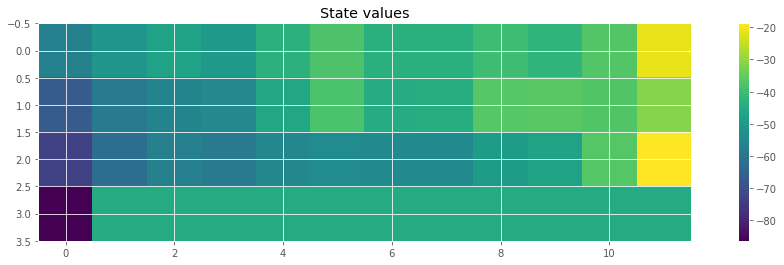

Episode 2500
Policy 36: [9.98196900e-01 1.45281036e-03 2.49600009e-04 1.00630976e-04], policy 24: [0.3938434  0.59780127 0.00399355 0.00436182]


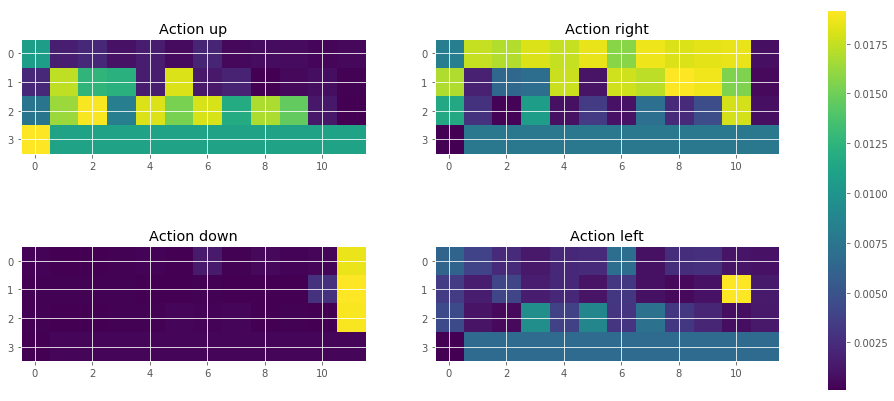

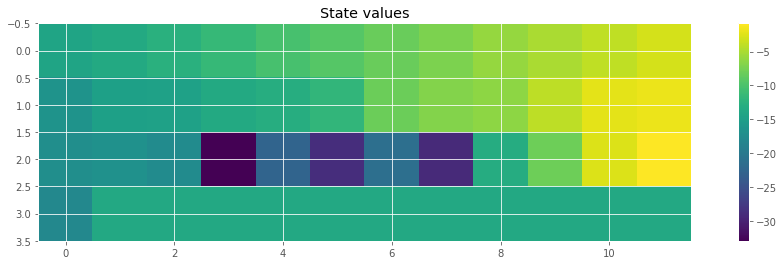

Episode 3000
Policy 36: [9.9757725e-01 2.2060999e-03 1.8074109e-04 3.5890760e-05], policy 24: [0.16198517 0.8359745  0.00111924 0.00092112]


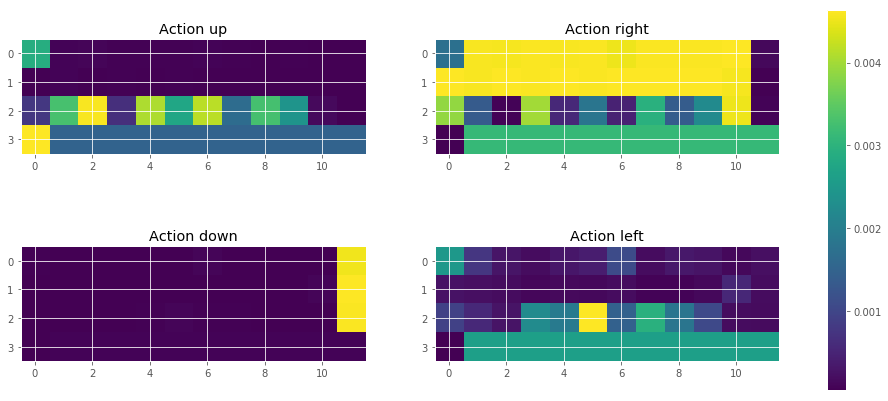

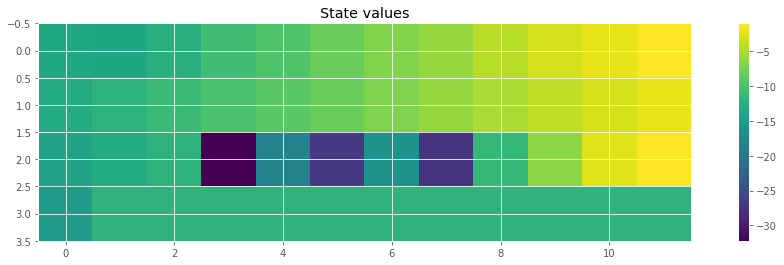

Episode 3500
Policy 36: [9.9721944e-01 2.5910414e-03 1.7543940e-04 1.4035224e-05], policy 24: [3.6844622e-02 9.6253210e-01 4.6225952e-04 1.6095767e-04]


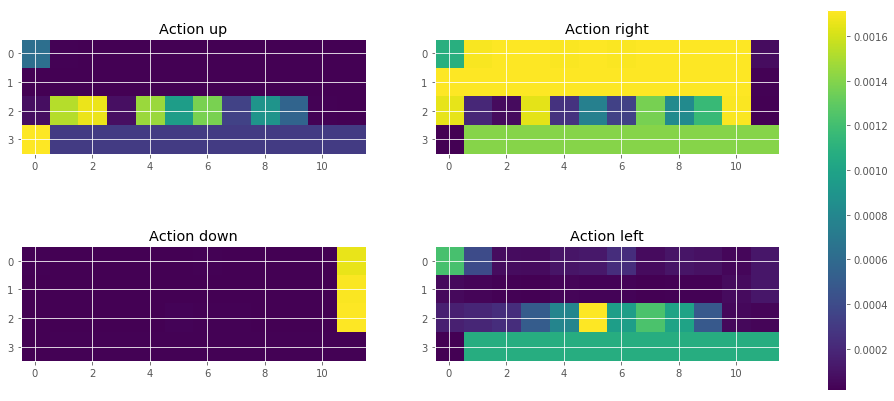

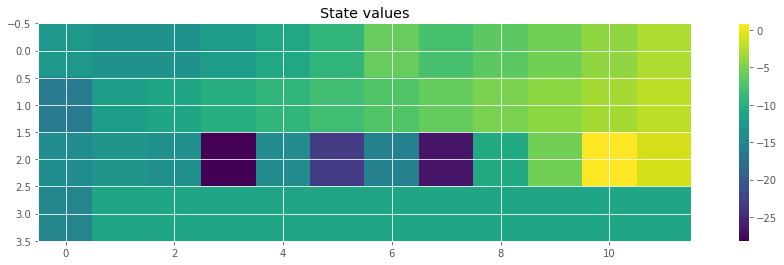

In [106]:
tf.reset_default_graph()
sess = tf.InteractiveSession()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PolicyEstimator(learning_rate=0.01)
value_estimator = ValueEstimator(learning_rate=0.1)
summary_writer = tf.summary.FileWriter('summary', sess.graph)

sess.run(tf.initialize_all_variables())
# Note, due to randomness in the policy the number of episodes you need to learn a good
# policy may vary. ~2000-5000 seemed to work well for me.
stats = reinforce(env, policy_estimator, value_estimator, 4000, discount_factor=1.0)

In [101]:
tf

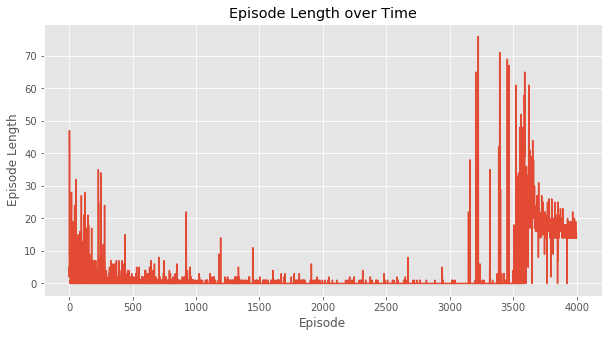

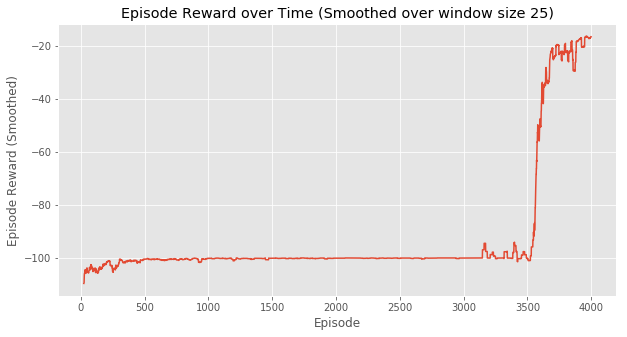

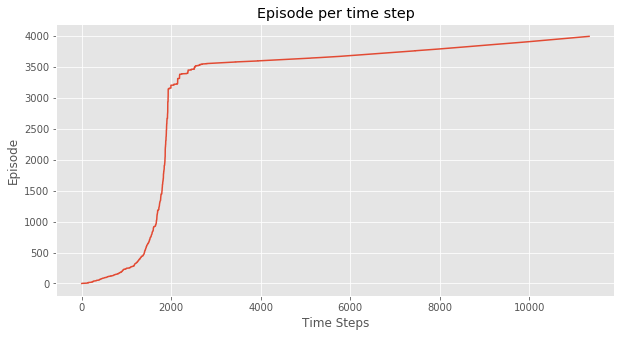

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [105]:
plotting.plot_episode_stats(stats, smoothing_window=25)